In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0)
        self.fc = nn.Linear(16 * 5 * 5, 11)
#         self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
#         self.fc = nn.Linear(32 * 1 * 1, 11)

    def forward(self, x):
        x = self.conv1(x)
#         x = self.relu(x)
        x = self.sigmoid(x)
#         x = self.maxpool(x)
        x = self.avgpool(x)
        x = self.conv2(x)
#         x = self.maxpool(x)
#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv4(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
#         x=self.sigmoid(x)
        return x

    
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16*16, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 128)
#         self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(512, 32)
        self.fc6 = nn.Linear(32, 11)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.relu(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
        x = self.fc5(x)
        x=self.relu(x)
        x = self.fc6(x)
        x=self.relu(x)
        return x

   

from torchvision import datasets

class MNISTWithNoiseDataset(Dataset):
    def __init__(self, root, noise_size=6000, transform=None):
        self.mnist = datasets.MNIST(root=root, train=True, download=True, transform=transform)
        self.noise_size = noise_size
        self.transform = transform
        self.classes = list(range(10)) + [10]  # Additional class index for noise

    def __getitem__(self, index):
        if index < len(self.mnist):
            img, target = self.mnist[index]
            return img, target
        else:
            noise = np.random.randint(0, 1, size=(28, 28)).astype(np.float64)
#             noise= torch.randn(1, 1, 28, 28)
#             noise = np.random.normal(0.1307, 0.3081, size=(28, 28))
            noise = Image.fromarray(noise)
            if self.transform:
                noise = self.transform(noise)
            return noise, 10  # Assign the additional class index for noise

    def __len__(self):
        return len(self.mnist) + self.noise_size


    
class MaskTransform(object):
    def __init__(self,threshold=0):
        self.threshold=threshold
        
    def __call__(self,  image):
        mask = torch.where(image > self.threshold, torch.tensor(1.0), torch.tensor(0.0))
        return mask
    
    
# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(16),
#     MaskTransform()
])

train_dataset = MNISTWithNoiseDataset(root='./data', noise_size=10000, transform=transform)
# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
# model = FCN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


for epoch in range(1, 11):
    train(epoch)


Train Epoch: 1 [0/70000 (0%)]	Loss: 2.445785
Train Epoch: 1 [6400/70000 (9%)]	Loss: 1.377699
Train Epoch: 1 [12800/70000 (18%)]	Loss: 0.649613
Train Epoch: 1 [19200/70000 (27%)]	Loss: 0.552102
Train Epoch: 1 [25600/70000 (37%)]	Loss: 0.343354
Train Epoch: 1 [32000/70000 (46%)]	Loss: 0.351053
Train Epoch: 1 [38400/70000 (55%)]	Loss: 0.563319
Train Epoch: 1 [44800/70000 (64%)]	Loss: 0.285521
Train Epoch: 1 [51200/70000 (73%)]	Loss: 0.395884
Train Epoch: 1 [57600/70000 (82%)]	Loss: 0.335480
Train Epoch: 1 [64000/70000 (91%)]	Loss: 0.333073
Train Epoch: 2 [0/70000 (0%)]	Loss: 0.292828
Train Epoch: 2 [6400/70000 (9%)]	Loss: 0.284087
Train Epoch: 2 [12800/70000 (18%)]	Loss: 0.653490
Train Epoch: 2 [19200/70000 (27%)]	Loss: 0.182381
Train Epoch: 2 [25600/70000 (37%)]	Loss: 0.199445
Train Epoch: 2 [32000/70000 (46%)]	Loss: 0.185422
Train Epoch: 2 [38400/70000 (55%)]	Loss: 0.212112
Train Epoch: 2 [44800/70000 (64%)]	Loss: 0.313960
Train Epoch: 2 [51200/70000 (73%)]	Loss: 0.161206
Train Epoch: 2

In [73]:
import pickle
with open('CNN_sigmod_avgpool_maskedTraining_3layers_zeroInitializeInputImage', 'wb') as f:
    pickle.dump(model, f)

In [74]:
from sklearn.metrics import confusion_matrix
# calculating the confusion matrix
model.eval()

# Initialize the lists to store the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test data batches
for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    # Forward pass to get the predicted outputs
    outputs = model(images)

    # Get the predicted labels
    _, predicted = torch.max(outputs.data, 1)

    # Append the true labels and predicted labels to the lists
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print(cm)

[[ 5753     0     7     3    17    25    27     5    71    15     0]
 [    1  6624    47     6    11    12     0     9    24     8     0]
 [   36    53  5405    81    91    16    60    85   100    31     0]
 [   28    28   107  5577     4   149    15    56    85    82     0]
 [    9    26    24     0  5502     0    35    23    30   193     0]
 [   29    23    21    67    39  5026    74    25    58    59     0]
 [   36    15    17     0    48    45  5725     3    27     2     0]
 [    9    25    73    22    51     9     0  5918    13   145     0]
 [   38    56    26    54    51    55    32     7  5456    76     0]
 [   25    24    15    37   264    23     2   121    43  5395     0]
 [    0     0     0     0     0     0     0     0     0     0 10000]]


In [75]:
def invert_image(num_steps=1000, lr=0.01):
#     model.eval()
    input_image=list()
    optimizer=list()
    target=list()
    
    for i in range(10):
#         input_image.append(torch.ones(1, 1, 16, 16, requires_grad=True, device=device))
        input_image.append(torch.zeros(1, 1, 16, 16, requires_grad=True, device=device))
        optimizer.append(optim.SGD([input_image[i]], lr=lr))
        target.append(torch.tensor([i], device=device))
    
    for step in range(num_steps+1):
        for i in range(10):
            optimizer[i].zero_grad()
            output = model(input_image[i])
            loss = criterion(output, target[i])
            loss.backward()
            optimizer[i].step()
            
        if step % 1000 == 0:
            print('Step: {} '.format(step))
    
    return input_image

inverted_images = invert_image()


Step: 0 
Step: 1000 


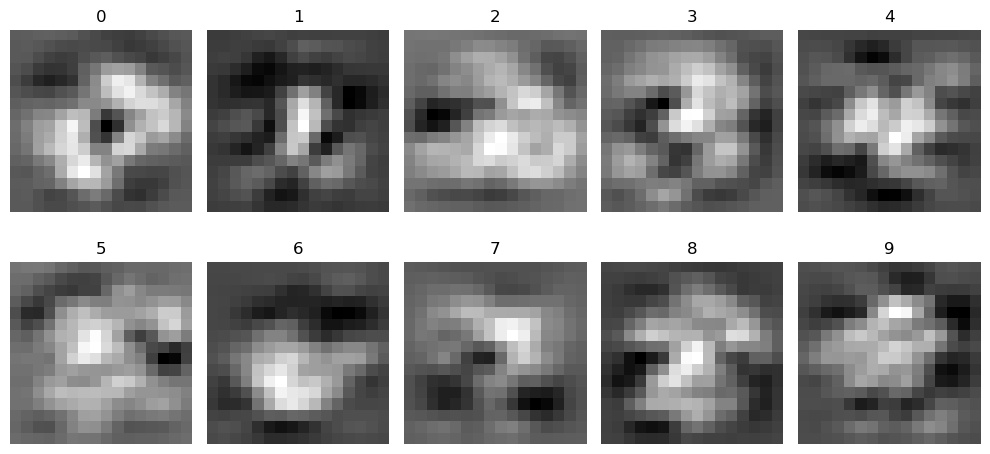

In [76]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(inverted_images[i].squeeze(0).squeeze(0).cpu().detach(), cmap='gray')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

plt.show()

**Next is a series of demostration of Targeted attack on the model using the differece of the target class inverted image from inverted image of other class, we are delibratly manupulating the input so that the model will misclassify in the target class**

In [77]:
#Calculatin the difference for each target class

difference=list()
for i in range(10):
    l=list()
    for j in range(10):
        l.append(inverted_images[i]-inverted_images[j])
    difference.append(l)
    

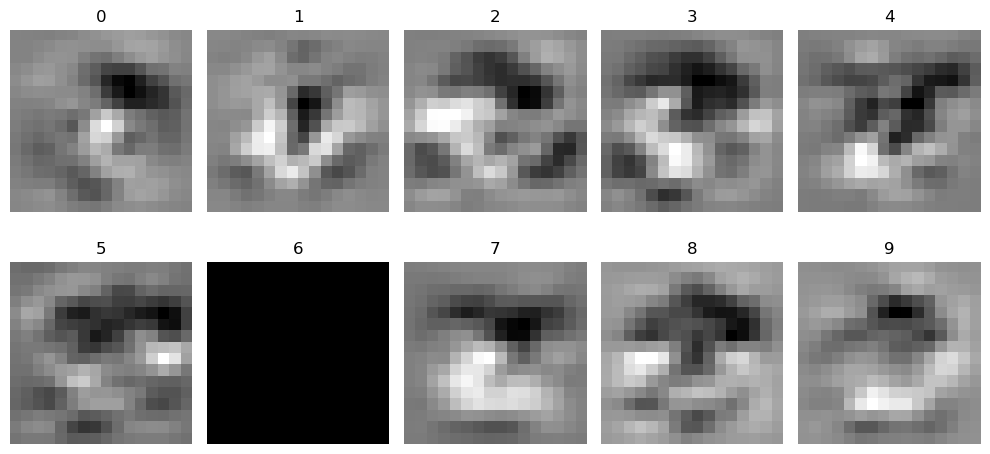

In [78]:
def plotDifference(target=0):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(difference[target][i].squeeze(0).squeeze(0).cpu().detach(), cmap='gray')
        ax.set_title(str(i))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotDifference(target=6)

In [79]:
#manupilating the model
def TargetedAttack(target=0):
    model.eval()

    # Initialize the lists to store the true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test data batches
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        for j, label in enumerate(labels):
            if label<10 and label != target:
                images[j]=images[j]+difference[target][label]
        # Forward pass to get the predicted outputs
        outputs = model(images)

        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Append the true labels and predicted labels to the lists
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

    # Convert the lists to NumPy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm

print(TargetedAttack(target=2))

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[[  858     0  4629   188     4   142    48     0    53     1     0]
 [    1     0  6692    37     0     0     0     6     6     0     0]
 [   36    53  5405    81    91    16    60    85   100    31     0]
 [  232     3  5009   385    12   102   236     7   135    10     0]
 [   16     4  5193   217   144    18    13     3   161    73     0]
 [   52     0  4173   963     7    53    53     8    89    23     0]
 [   31     0  5755    45     4    18    52     0    13     0     0]
 [  144     7  5686    95     8    58    47    21    63   136     0]
 [   35     3  5494   138    10    39    37     2    87     6     0]
 [   28     3  5362   390   108     6     0    33    12     7     0]
 [    0     0     0     0     0     0     0     0     0     0 10000]]


Step: 0 	loss: 10.232691764831543
Step: 100 	loss: 1.1920928244535389e-07
Step: 200 	loss: 1.1920928244535389e-07
Step: 300 	loss: 1.1920928244535389e-07
Step: 400 	loss: 1.1920928244535389e-07
Step: 500 	loss: 1.1920928244535389e-07
Step: 600 	loss: 1.1920928244535389e-07
Step: 700 	loss: 1.1920928244535389e-07
Step: 800 	loss: 1.1920928244535389e-07
Step: 900 	loss: 1.1920928244535389e-07
Step: 1000 	loss: 1.1920928244535389e-07
Step: 1100 	loss: 1.1920928244535389e-07
Step: 1200 	loss: 1.1920928244535389e-07
Step: 1300 	loss: 1.1920928244535389e-07
Step: 1400 	loss: 1.1920928244535389e-07
Step: 1500 	loss: 1.1920928244535389e-07
Step: 1600 	loss: 1.1920928244535389e-07
Step: 1700 	loss: 1.1920928244535389e-07
Step: 1800 	loss: 1.1920928244535389e-07
Step: 1900 	loss: 1.1920928244535389e-07
Step: 2000 	loss: 1.1920928244535389e-07
Step: 2100 	loss: 1.1920928244535389e-07
Step: 2200 	loss: 1.1920928244535389e-07
Step: 2300 	loss: 1.1920928244535389e-07
Step: 2400 	loss: 1.192092824453

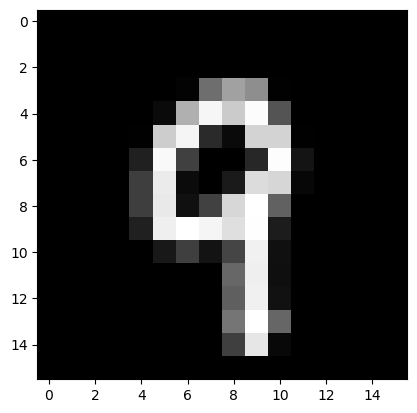

In [105]:

data=train_dataset[350]
input_image=data[0].to(device).clone().detach()
plt.imshow(data[0][0], cmap='gray')
input_image.requires_grad_(True)

# input_image.requires_grad_(True)
optimizer=optim.SGD([input_image], lr=0.4)
target=torch.tensor([data[1]-6], device=device)
input_image=input_image.to(device)

def generate_image(num_steps=5000):
    for step in range(num_steps+1):
        optimizer.zero_grad()
        output = model(input_image.unsqueeze(0))
        loss = criterion(output, target)
        loss.backward()
#         print(input_image.grad)
        optimizer.step()

        if step % 100 == 0:
            print('Step: {} \tloss: {}'.format(step,loss.item()))
    
    return input_image
output_image=generate_image()

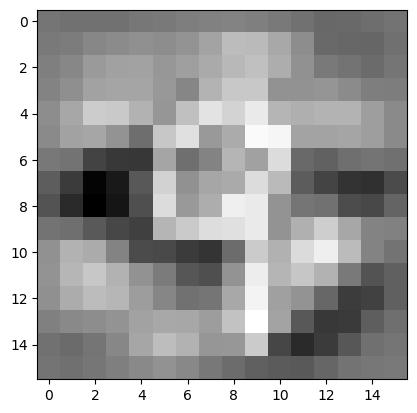

In [106]:
plt.imshow(output_image[0].cpu().detach(), cmap='gray')